In [8]:
import os
import pandas as pd
import numpy as np
import torch

import random
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import crossprob
from tqdm import tqdm
import random
import pickle as pkl

from prompt_risk.bounds import *
from prompt_risk.utils import *

from matplotlib import style
plt.style.use('seaborn-v0_8')


In [17]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR",
    "gini": "Gini"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = 40,
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    save_result = False,
    ymax=1.0
):

    output_dir = '../llm_output'
    
    sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))
    print(sum_df.columns)
    
    sum_df = sum_df.drop(['seed', 'max_new_tokens', 'do_sample',
           'stop_sequences', 'response_time', 'tokens_per_second',
           'milliseconds_per_token', 'torch_allocated_GBs',
           'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
           'generated_tokens'], axis=1)
    
    prompt_list = sum_df["hypothesis"].unique()
    res = []
    for p in prompt_list:
    
        prompt_df = sum_df[sum_df["hypothesis"] == p]
        scores = np.array(prompt_df["rougeL"].tolist())
        queries = [q for q in prompt_df["text"].tolist()]
        responses = prompt_df["generated_text"].tolist()

        if np.mean(scores) < 1.0:
            res.append([
                p,
                1-scores,
                queries,
                responses
            ])
    
        # print(p)
        # print(np.mean(scores), np.std(scores))
        # print(len(scores))
        # print("-------")

    num_hypotheses = len(res)

    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bj_bounds = dict()
    correction = delta/(num_hypotheses)
    # correction = delta/(num_hypotheses)

    stats = []
    
    plt.rcParams["figure.figsize"] = [9,3]
    fig, axs = plt.subplots(1,2, width_ratios=[4,4])
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0

    best_ins = None
    prc_ins = None
    bnd_ins = None

    best_rew = 1.0
    prc_rew = 1.0
    best_bnd = 1.0
    
    for instruction, X, query_texts, chat_responses in res:

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]

        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in ["cvar", "var-int"]:
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        # if emp_mean_cal < 0.75:
        #     ins_idx += 1
        #     continue
        # if emp_mean_cal > 0.8:
        #     ins_idx += 1
        #     continue

        s = {
            "idx": ins_idx,
            "instruction": instruction,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3
        
        # if ins_idx in interest_inds:

        #     if bound_val < alpha:
        #         p_label = r"$p^*_{safe}$"
        #     else:
        #         p_label = r"$p^*$"

        #     # axs[1].plot(np.arange(n_test)/n_test, np.cumsum(X_test_sorted)/np.sum(X_test_sorted), label=p_label, color=pal[disp_idx])

        #     low_var_ind = int(X_test.shape[0]*(1-beta_min))
        #     var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
        #     var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
        #     chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
        #     chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

        #     # axs[0].scatter(
        #     #     1-emp_mean_cal, bound_val, 
        #     #     label=p_label, 
        #     #     color=pal[disp_idx], 
        #     #     marker="P", 
        #     #     # zorder=1000, 
        #     #     s=250
        #     # )
            
        #     # print("Text@Low VaR:", 1-beta_min)
        #     # for ctr, v in enumerate(var_chat_out):
        #     #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
        #     #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
        #     #     print(var_text[ctr], v)
        #     #     print()
        #     # print()
            
        #     var_ind = int(X_test.shape[0]*beta_min)
        #     var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
        #     var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
        #     chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
        #     chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
        #     # print("Text@VaR:", beta_min)
        #     # for ctr, v in enumerate(var_chat_out):
        #     #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
        #     #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
        #     #     print(var_text[ctr], v)
        #     #     print()
        #     disp_idx += 1

        if emp_mean_cal < best_rew:
            best_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            best_rew = emp_mean_cal
            
        if (emp_mean_cal < prc_rew) and (bound_val < alpha):
            prc_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            prc_rew = emp_mean_cal

        if (bound_val < best_bnd):
            bnd_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            best_bnd = bound_val

        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    # for s in stats:
    #     for key, value in s.items():
    #         print(key, value)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    # axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([0.0, 1.0], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")

    # axs[0].set_xlim(0.25, 0.4)
    # axs[0].set_ylim(0.3, 0.45)
    axs[0].set_xlim(0.0, ymax)
    axs[0].set_ylim(0.0, ymax)

    print("best", best_ins["ins_idx"], best_ins["bound_val"], best_ins["emp_meas_test"])
    print("prc", prc_ins["ins_idx"], prc_ins["bound_val"], prc_ins["emp_meas_test"])
    print("bnd", bnd_ins["ins_idx"], bnd_ins["bound_val"], bnd_ins["emp_meas_test"])

    axs[0].scatter(
        best_ins["rew_cal"], best_ins["bound_val"], 
        label=r"$p^*_{RGE}$", 
        color=pal[0], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(best_ins["X_test"])/np.sum(best_ins["X_test"]), label=r"$p^*_{RGE}$", color=pal[0])
    
    axs[0].scatter(
        prc_ins["rew_cal"], prc_ins["bound_val"], 
        label=r"$p^*_{PRC}$", 
        color=pal[1], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(prc_ins["X_test"])/np.sum(prc_ins["X_test"]), label=r"$p^*_{PRC}$", color=pal[1])

    # axs[1].plot(np.arange(n_test)/n_test, np.cumsum(bnd_ins["X_test"])/np.sum(bnd_ins["X_test"]), label=r"$p^{safe}$", color=pal[1])

    axs[1].plot([0.0, 1.0], [0.0, 1.0], "--", color=pal[2], label="Line of Equality")

    axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$p_i$")

    axs[0].set_xlabel(r"Avg. Rouge-L ($\uparrow$)", fontsize=14)    
    axs[0].set_ylabel(r"Gini Co-eff. Risk Bound ($\hat{R}$)", fontsize=13)    
    axs[1].set_xlabel(r"$\beta$ (Quantile)", fontsize=14)    
    axs[1].set_ylabel("Cum. Loss Share", fontsize=13)    

    axs[0].legend(
        loc="lower right", 
        ncols=2, 
        # frameon=True
    )
    axs[1].legend(
        loc="upper left", 
        # ncols=2, 
        # frameon=True
    )

    axs[0].set_title(left_title, fontsize=14)    
    axs[1].set_title(right_title, fontsize=14)    
    
    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        print("saving to", save_root)
        plt.savefig(save_root, bbox_inches="tight", dpi=600)

    plt.show()

/tmp/ipykernel_7391/1433264350.py:39: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
best 31 0.45579639534890815 0.210532804664001
prc 10 0.31484306623276126 0.15531642566337905
bnd 7 0.09868606158679838 0.03573323768250268
saving to ../plots/medqsum/medqsum_model_40_rougeL_gini_loss_dist_with_text.png


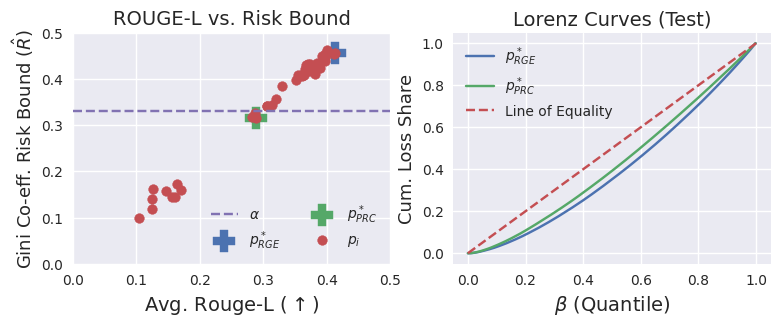

In [18]:
plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=500,
    left_title = r"ROUGE-L vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.33,
    ymax=0.5,
    save_result=True,
)